<a href="https://colab.research.google.com/github/alinarogova/HW/blob/master/%D0%94%D0%97_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree
import graphviz

In [87]:
df = pd.read_csv("https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module2/data/ship_passengers.csv",
                 index_col="Unnamed: 0")

In [88]:
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [89]:
df = df[['pclass', 'age', 'embarked', 'fare']]
df.head()

,pclass,age,embarked,fare
0,3,22.0,S,7.2500
1,1,38.0,C,71.2833
2,3,26.0,S,7.9250
3,1,35.0,S,53.1000
4,3,35.0,S,8.0500


In [90]:
df['pclass']=df['pclass'].astype(np.object_)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    object 
 1   age       714 non-null    float64
 2   embarked  889 non-null    object 
 3   fare      891 non-null    float64
dtypes: float64(2), object(2)
memory usage: 34.8+ KB


# Завдання 1
Очистіть дані від викидів(лише `fare`), розділіть на тренувальну та тестову чатини

In [91]:
df.describe()

,age,fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


<Axes: >

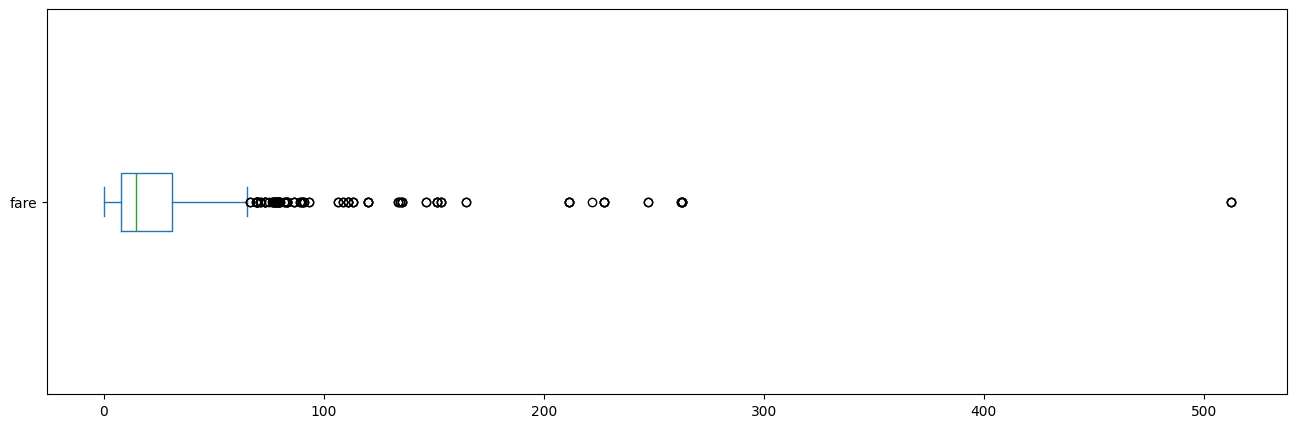

In [92]:
df['fare'].plot(kind="box", vert=False, figsize=(16,5))

In [93]:
(df['fare']>400).sum()

3

In [94]:
(df['fare']>200).sum()

20

<Axes: >

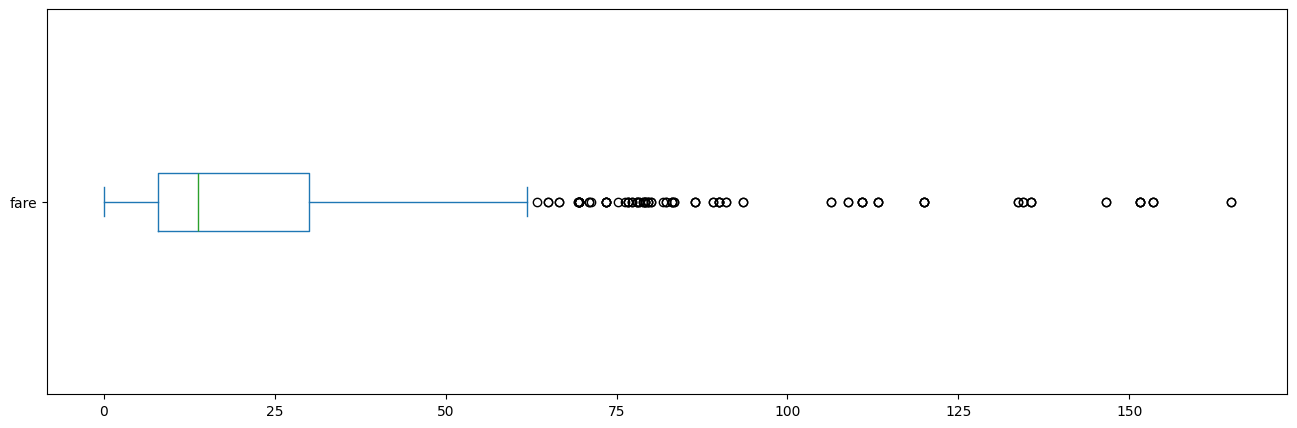

In [95]:
df=df[df['fare']<200]
df['fare'].plot(kind="box", vert=False, figsize=(16,5))

# Завдання 2
Створіть Pipeline для обробки даних

In [96]:
from sklearn.model_selection import train_test_split

y = df['fare']
X = df.drop(columns='fare')

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)
X_train.head()

,pclass,age,embarked
676,3,24.5,S
467,1,56.0,S
533,3,NaN,C
763,1,36.0,S
372,3,19.0,S


In [97]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

num_columns = X_train.select_dtypes(include='number').columns
cat_columns = X_train.select_dtypes(include='object').columns

num_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])



cat_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder())
])


preprocessor = ColumnTransformer([
    ('num', num_transformer, num_columns),
    ('cat', cat_transformer, cat_columns)
])

preprocessor.set_output(transform='pandas')
preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['age'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode', OrdinalEncoder())]),
                                 Index(['pclass', 'embarked'], dtype='object'))])

# Завдання 3
Об'єднайте дерево рішень з препроцесором та натренуйте їх

In [98]:
from sklearn.tree import DecisionTreeRegressor

preprocessor.fit_transform(X_train)


full_model = Pipeline([
    ('prep', preprocessor),
    ('tree', DecisionTreeRegressor(max_depth=4))
])
full_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['age'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder())]),
                                                  Index(['pclass', 'embarked'], dtype='object'))])),
                ('tree', DecisionTreeRegressor(max_depth=4))])

# Завдання 4
Виведіть основні метрики моделі

In [99]:
from sklearn import metrics
y_pred = full_model.predict(X_test)

old_r2 = metrics.r2_score(y_pred, y_test)
old_r2

0.28269526904806297

In [100]:
metrics.r2_score(y_test, y_pred)

0.49232017527475413

In [101]:
dot_data = tree.export_graphviz(full_model['tree'], out_file=None,
                                feature_names = full_model['tree'].feature_names_in_) # вказуємо назви стовпчиків

graph = graphviz.Source(dot_data)
graph.render("titanic tree")

'titanic tree.pdf'

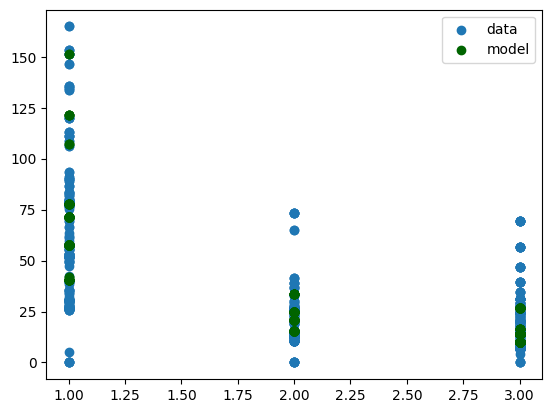

In [102]:
plt.scatter(X['pclass'], y, label='data')
plt.scatter(X['pclass'], full_model.predict(X), c='darkgreen', label='model')
plt.legend()

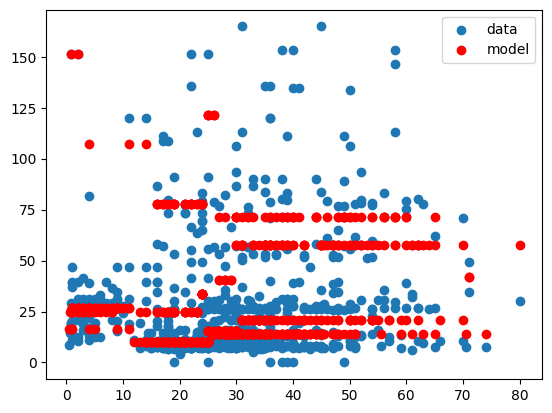

In [103]:
plt.scatter(X['age'], y, label='data')
plt.scatter(X['age'], full_model.predict(X), c='red', label='model')
plt.legend()

# Завдання 5
Змініть параметри моделі та попробуйте покращити результат

Попробуйте:
* не видаляти викиди
* змінити обробку даних(imputer(SimpleImputer vs KNNImputer) та кодування категоріальних даних(OneHotEncoder vs OrdinaryEncoder))
* змінити параметри дерева(глибина, кількість точок у листках тощо)


Спробуємо змінити обробку даних(imputer(SimpleImputer vs KNNImputer)

In [104]:
from sklearn.impute import KNNImputer
def run_model(n_neighbors=5, max_depth=4):
  num_transformer = Pipeline([
      ('impute', KNNImputer(n_neighbors=n_neighbors))
  ])

  cat_transformer = Pipeline([
      ('encode', OrdinalEncoder()),
      ('impute', KNNImputer(n_neighbors=n_neighbors))
  ])

  preprocessor = ColumnTransformer([
      ('num', num_transformer, num_columns),
      ('cat', cat_transformer, cat_columns)
  ])

  preprocessor.set_output(transform='pandas')
  preprocessor.fit_transform(X_train)
  full_model = Pipeline([
    ('prep', preprocessor),
    ('tree', DecisionTreeRegressor(max_depth=4))
  ])

  full_model.fit(X_train, y_train)

  y_pred = full_model.predict(X_test)
  return metrics.r2_score(y_pred, y_test)

def run_model_OneHotEncoder(n_neighbors=5, max_depth=4):
  num_transformer = Pipeline([
      ('impute', KNNImputer(n_neighbors=n_neighbors))
  ])

  cat_transformer = Pipeline([
      ('encode', OneHotEncoder(sparse_output=False)),
      ('impute', KNNImputer(n_neighbors=n_neighbors))
  ])

  preprocessor = ColumnTransformer([
      ('num', num_transformer, num_columns),
      ('cat', cat_transformer, cat_columns)
  ])

  preprocessor.set_output(transform='pandas')
  preprocessor.fit_transform(X_train)
  full_model = Pipeline([
    ('prep', preprocessor),
    ('tree', DecisionTreeRegressor(max_depth=4))
  ])

  full_model.fit(X_train, y_train)

  y_pred = full_model.predict(X_test)
  return metrics.r2_score(y_pred, y_test)


In [105]:
print("OrdinaryEncoder")
for n_neighbors in (2,3,5):
  for max_depth in (2,3,4):
    print(f"KKNImputer with {n_neighbors} neighbors and Tree Regressor with {max_depth} max_depth : {run_model(n_neighbors=n_neighbors, max_depth=max_depth)};")
print(f'SimpleImputer: {old_r2}')
print("OneHotEncoder")
for n_neighbors in (2,3,5):
  for max_depth in (2,3,4):
    print(f"KKNImputer with {n_neighbors} neighbors and Tree Regressor with {max_depth} max_depth : {run_model_OneHotEncoder(n_neighbors=n_neighbors, max_depth=max_depth)};")

OrdinaryEncoder
KKNImputer with 2 neighbors and Tree Regressor with 2 max_depth : 0.22856501104666227;
KKNImputer with 2 neighbors and Tree Regressor with 3 max_depth : 0.22856501104666238;
KKNImputer with 2 neighbors and Tree Regressor with 4 max_depth : 0.22856501104666216;
KKNImputer with 3 neighbors and Tree Regressor with 2 max_depth : 0.22856501104666238;
KKNImputer with 3 neighbors and Tree Regressor with 3 max_depth : 0.22856501104666227;
KKNImputer with 3 neighbors and Tree Regressor with 4 max_depth : 0.22856501104666216;
KKNImputer with 5 neighbors and Tree Regressor with 2 max_depth : 0.24276451556921508;
KKNImputer with 5 neighbors and Tree Regressor with 3 max_depth : 0.24276451556921497;
KKNImputer with 5 neighbors and Tree Regressor with 4 max_depth : 0.24276451556921508;
SimpleImputer: 0.28269526904806297
OneHotEncoder
KKNImputer with 2 neighbors and Tree Regressor with 2 max_depth : 0.24276451556921508;
KKNImputer with 2 neighbors and Tree Regressor with 3 max_depth :

# Завдання 6
Збережіть модель

In [106]:
num_transformer = Pipeline([
    ('impute', KNNImputer(n_neighbors=2))
])

cat_transformer = Pipeline([
    ('encode', OneHotEncoder(sparse_output=False)),
    ('impute', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_columns),
    ('cat', cat_transformer, cat_columns)
])

preprocessor.set_output(transform='pandas')

preprocessor.fit_transform(X_train)


full_model = Pipeline([
    ('prep', preprocessor),
    ('tree', DecisionTreeRegressor(max_depth=2))
])

full_model.fit(X_train, y_train)

y_pred = full_model.predict(X_test)

metrics.r2_score(y_pred, y_test)

0.13953541685117632

In [107]:
import joblib
joblib.dump(full_model, 'model.pkl')
loaded_model = joblib.load('model.pkl')
loaded_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(n_neighbors=2))]),
                                                  Index(['age'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(sparse_output=False)),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['pclass', 'embarked'], dtype='object'))])),
                ('tree', DecisionTreeRegressor(max_depth=2))])

In [108]:
dot_data = tree.export_graphviz(full_model['tree'], out_file=None,
                                feature_names = full_model['tree'].feature_names_in_) # вказуємо назви стовпчиків

graph = graphviz.Source(dot_data)
graph.render("titanic tree")

'titanic tree.pdf'